In [ ]:
import anndata
import numpy as np
import seaborn as sb
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import scanpy as sc
warnings.filterwarnings("ignore")

from genes2genes import Main
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyser
from genes2genes import VisualUtils

In [1]:
import pyscenic
print(pyscenic.__version__)

0.12.1


In [4]:
adata_ref = anndata.read_h5ad('/sc/arion/projects/CommonMind/aging/hui/submission/files/integrated_EN_con_adata.h5ad')
subtypes_to_keep= ["PN_dev", "L2-3_CUX2_dev-fetal", "L2-3_CUX2_dev-4", "L2-3_CUX2_dev-6", "L2-3_CUX2_dev-2", "L2-3_CUX2_dev-3", "L2-3_CUX2_dev-5", "L2-3_CUX2_dev-1", "L2_CUX2_LAMP5_dev", "L2_CUX2_LAMP5", "L3_CUX2_PRSS12", "EN_L2_3_IT_NTNG1", "EN_L2_3_IT_PDGFD"]
adata_ref=adata_ref[adata_ref.obs.subtype_uni.isin(subtypes_to_keep)]

In [5]:
adata_ref.obs['stage_id'] = adata_ref.obs['stage_id'].str.replace(r'(Middle|Late|Young)_Adulthood', 'Adulthood', regex=True)
adata_ref.obs.stage_id.value_counts()

stage_id
Adulthood      127765
Adolescence     23528
Childhood        8402
Fetal            7714
Infancy          5638
Neonatal         2130
Name: count, dtype: int64

In [6]:
import random
random.seed(42)
Adulthood=random.sample(adata_ref.obs[adata_ref.obs.stage_id=='Adolescence'].index.tolist(), 5000,)
Adolescence=random.sample(adata_ref.obs[adata_ref.obs.stage_id=='Adulthood'].index.tolist(), 5000)
Others= adata_ref.obs[~adata_ref.obs.stage_id.isin(["Adolescence","Adulthood"])].index.tolist()
combined_list = Adulthood + Adolescence + Others
adata_ref=adata_ref[combined_list,]

In [7]:
ref_psedotime = pd.read_table('./data/psychad.meta.txt')
cells_ref=adata_ref.obs.index.intersection(ref_psedotime.index) 
adata_ref=adata_ref[cells_ref]
adata_ref.obs['time']=ref_psedotime.loc[adata_ref.obs.index,'time']


In [8]:
#adata_query = anndata.read_h5ad('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge.h5ad')
adata_query = anndata.read_h5ad('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge_rawcount.h5ad')
# Normalizing to median total counts
sc.pp.normalize_total(adata_query,target_sum=1e6)
# Logarithmize the data
sc.pp.log1p(adata_query)


In [9]:
query_psedotime = pd.read_table('./data/integrate_entnn_pseduotime_meta.txt')

In [10]:
adata_query=adata_query[query_psedotime.index]
adata_query.obs['time']=query_psedotime.loc[adata_query.obs.index,'monocle3_pseudotime']
adata_query.obs['pseudotime']=query_psedotime.loc[adata_query.obs.index,'monocle3_pseudotime']
adata_query.obs['N_types']=query_psedotime.loc[adata_query.obs.index,'cca_N_types']
adata_query.obs['N_types_stage']=query_psedotime.loc[adata_query.obs.index,'cca_N_types_stage']


In [11]:
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

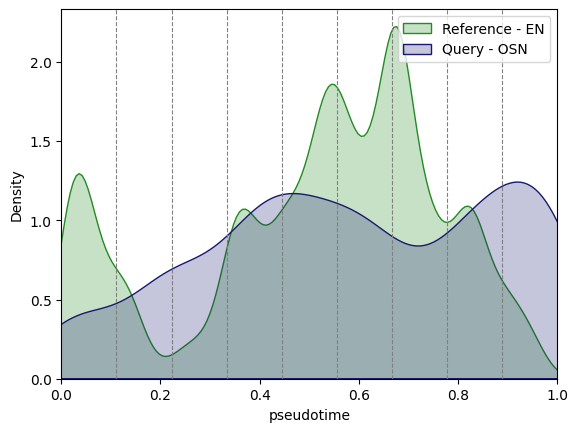

In [12]:
# Visualize thcolumnsseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Reference - EN', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Query - OSN', color='midnightblue'); 
plt.xlim(0, 1)
x_min, x_max = plt.xlim()
num_lines = 8
line_positions = np.linspace(x_min, x_max, num_lines + 2)[1:-1]  # Exclude the endpoints

# Add vertical lines
for pos in line_positions:
    plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.8)

# Show the plot
plt.xlabel('pseudotime'); plt.legend(); plt.show()
# Calculate the x-axis limits and add vertical lines


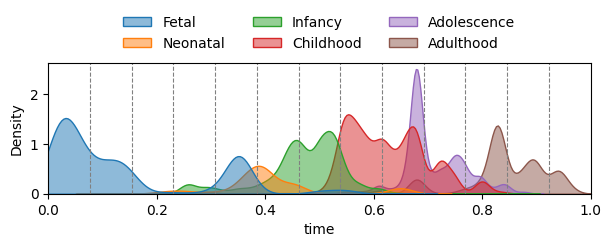

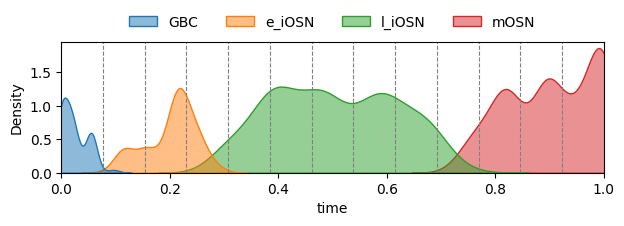

In [13]:
adata_ref.obs['stage_id'] = pd.Categorical(adata_ref.obs['stage_id'], 
                            categories=['Fetal', 'Neonatal','Infancy', 'Childhood','Adolescence','Adulthood'], 
                            ordered=True)


plt.figure(figsize=(7, 1.7))  # 8 inches wide and 6 inches tall

#ax=sb.kdeplot(data=adata_ref.obs, x='time', hue='stage_id', fill=True, alpha=0.5,palette="crest")
ax=sb.kdeplot(data=adata_ref.obs, x='time', hue='stage_id', fill=True, alpha=0.5)
plt.xlim(0, 1)

# Calculate the x-axis limits and add vertical lines
x_min, x_max = plt.xlim()
num_lines = 12
line_positions = np.linspace(x_min, x_max, num_lines + 2)[1:-1]  # Exclude the endpoints

# Add vertical lines
for pos in line_positions:
    plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.8)


sb.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, 1), ncol=3, title=None, frameon=False,
) 

plt.savefig('./figures/g2g_hui.pdf', format='pdf', bbox_inches='tight')  # Save as PDF

#################

adata_query.obs['N_types_stage'] = pd.Categorical(adata_query.obs['N_types_stage'], 
                            categories=['GBC','e_iOSN','l_iOSN','mOSN'], 
                            ordered=True)

plt.figure(figsize=(7, 1.7))  # 8 inches wide and 6 inches tall

ax= sb.kdeplot(data=adata_query.obs, x='time', hue='N_types_stage', fill=True, alpha=0.5)
plt.xlim(0, 1)

# Calculate the x-axis limits and add vertical lines
x_min, x_max = plt.xlim()
num_lines = 12
line_positions = np.linspace(x_min, x_max, num_lines + 2)[1:-1]  # Exclude the endpoints

# Add vertical lines
for pos in line_positions:
    plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.8)

sb.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, 1), ncol=4, title=None, frameon=False,
) 

plt.savefig('./figures/g2g_ent.pdf', format='pdf', bbox_inches='tight')  # Save as PDF


In [14]:
from optbinning import ContinuousOptimalBinning

x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

(CVXPY) Dec 10 02:13:04 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 10 02:13:04 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
13
14


In [15]:
n_bins = 13
#define the gene list to align
# gene_list = adata_ref.var_names.intersection(adata_query.var_names)
# gene_list = adata_ref.var[adata_ref.var['highly_variable']].index.intersection(adata_query.var_names)

#EN_DEG=pd.read_table('/sc/arion/projects/CommonMind/aging/hui/submission/files/traDEGs/EN_traDEG_L2_3_IT.txt')
#EN_DEG=EN_DEG[(EN_DEG.q_value < 0.05) & (EN_DEG.morans_I > 0.05)]


#EN_DEG=pd.read_table("./data/en_degs.txt")
#OSN_DEG=pd.read_table("./data/DEG_trend_Olf.txt")
#DEGs=pd.concat([EN_DEG.V1, OSN_DEG.gene])
#DEGs=pd.concat([EN_DEG.gene_name, OSN_DEG.gene])
#DEGs=np.intersect1d(EN_DEG.gene_name, OSN_DEG.gene)

#DEGs = pd.read_table('/sc/arion/projects/roussp01a/liting/Olf/data/CNON.DE.txt').Symbol#[1:81]
#DEGs = pd.read_table('/sc/arion/projects/roussp01a/liting/Olf/data/CNON.DE.txt').Symbol#[1:81]
DEGs = pd.read_table('/sc/arion/projects/roussp01a/liting/Olf/data/SFARI.txt')#.Symbol#[1:81]
DEGs= DEGs['gene-symbol'][(DEGs["syndromic"]==1) | (DEGs["gene-score"]==1)]
DEGs1 =np.intersect1d( adata_query.var_names,DEGs)
DEGs2 =np.intersect1d( adata_ref.var_names,DEGs1)

# topDEgenes = df[list(df['alignment_similarity_percentage'] >=0.5)]['Gene']
# topDEgenes.values
gene_list=DEGs2#topDEgenes.values #

aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins) #

aligner.align_all_pairs() 

Genes2Genes (v0.2.0)
Dynamic programming alignment of gene pseudotime trajectories using a bayesian information-theoretic framework
Interpolator initialization completed
Aligner initialised to align trajectories of 33107 reference cells & 891 query cells in terms of 375 genes
Running gene-level alignment: 🧬


100%|██████████| 375/375 [00:41<00:00,  9.08it/s]

Alignment completed! ✅


Average Alignment:  IIIDIDIDIDIIIIDDDDMMMDD (cell-level)
% similarity: 13.04


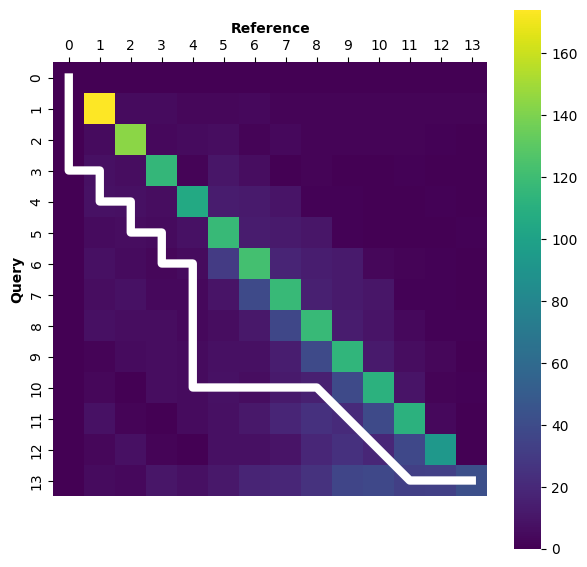

In [16]:
#Aggregate (average) cell-level alignment across all aligned genes
aligner.get_aggregate_alignment() 

Compute distance matrix
- using hamming distance metric
Experimental mode: exploring different thresholds


 66%|██████▌   | 65/99 [00:00<00:00, 190.36it/s]


-- Cluster diagnostic plots
Potential candidates for distance threshold: a locally optimal thresholds that gives a good trade-off between high mean Silhouette score and low number of clusters 
Compute distance matrix
- using hamming distance metric
run agglomerative clustering | distance threshold = 0.3
silhouette_score:  0.5011801432170795
cluster:  0 IIIDIDIDIDIIIDDDMMMMDD ( 42 genes)
cluster:  1 MMMMMMMMMIMMMD ( 137 genes)
cluster:  2 IIIDIMMMMMMMMWMDD ( 12 genes)
cluster:  3 IIIDIDIDIDIIIIDMMMWWWWD ( 22 genes)
cluster:  4 IIIIIMMDDMMMMMMDDD ( 2 genes)
cluster:  5 IIIDIDIDIDIIIIIIIDDDDDDDDD ( 81 genes)
cluster:  6 IIIDMIDDDMMMMIIIMDDD ( 19 genes)
cluster:  7 IDDDDDMMMIIDMMIMVVM ( 1 genes)
cluster:  8 IIIDIMDDMMMMMMMMD ( 53 genes)
cluster:  9 IIIIMVVVMVMWMMDDDDDDD ( 2 genes)
cluster:  10 IIIIIIMMMDDDDMMMWMD ( 2 genes)
cluster:  11 MMMMMVVMIIIIDIDDDDDD ( 2 genes)


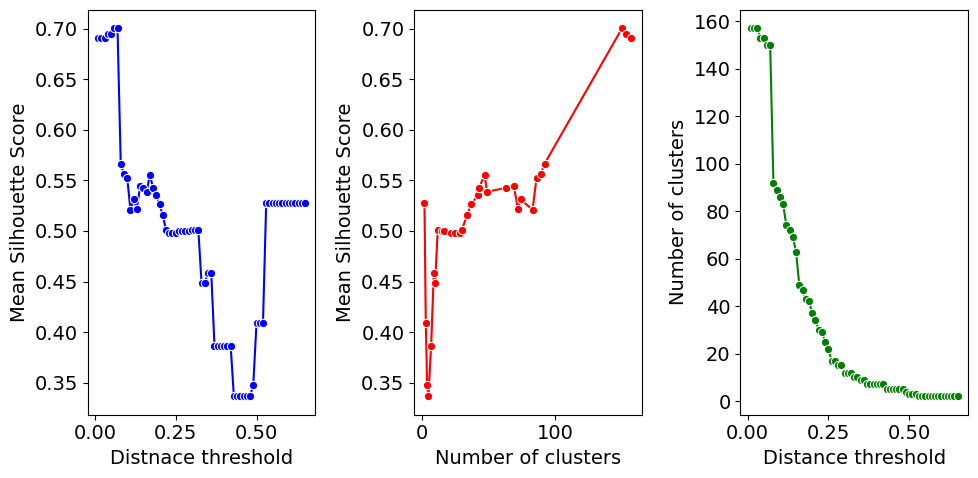

<Figure size 700x700 with 0 Axes>

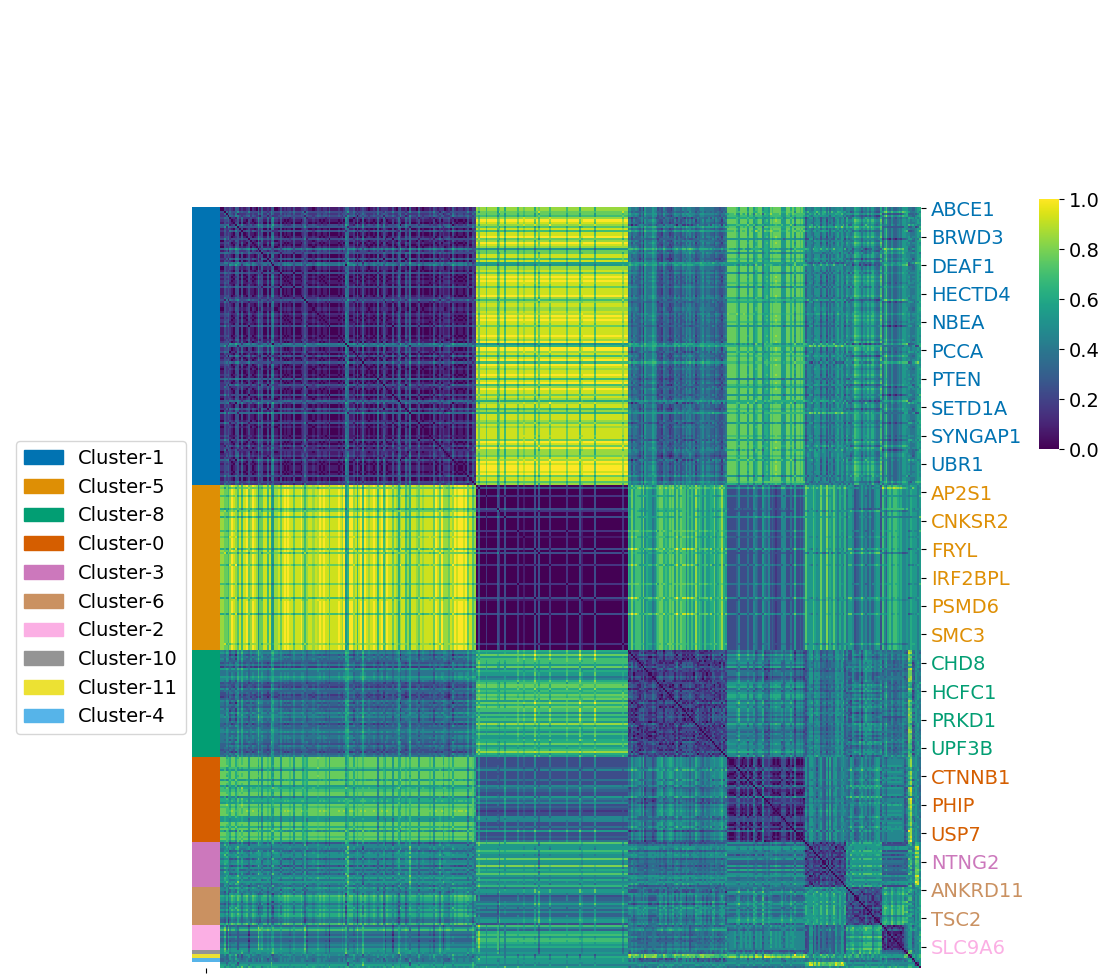

In [26]:
# cluster

df = ClusterUtils.run_clustering(aligner, metric='hamming', experiment_mode=True) 
ClusterUtils.run_clustering(aligner, metric='hamming', DIST_THRESHOLD=0.3) 
plt.figure(figsize=(7, 7))  # 8 inches wide and 6 inches tall
VisualUtils.plot_distmap_with_clusters(aligner)
plt.savefig('./figures/g2g_Cluster.pdf', format='pdf', bbox_inches='tight')  # Save as PDF

ClusterUtils.print_cluster_average_alignments(aligner)


# pattern <- list(
# 'IIIDMIDDDMMMMIIIMDDD' = 'Middle convergence',
# 'IIIDIDIDIDIIIIIIIDDDDDDDDD'= 'Mismatch',
# 'IIIDIIIMMMDMMMMWWWD'= 'Middle convergence',
# 'MMMIIDMMMMMMMMD' ='Match',
# 'IDDDDDMMMIIDMMIMVVM'= '6',
# 'IIIIMVVVMVMWMMDDDDDDD' = '7',
# 'MMMMMVVMIIIIDIDDDDDD'= '8')

In [72]:
#pd.DataFrame.from_dict(aligner.gene_clusters, orient='index').transpose()
ClusterUtils.print_cluster_average_alignments(aligner)

pattern <- list('MMMIIDMMMMMMMMD' = 'Match',
 'IIIDIDIDIDIIIIIIIDDDDDDDDD' = 'Mismatch',
 'IIIDIIIMMMDMMMMWWWD' = 'Middle convergence',
 'IDDDDDMMMIIDMMIMVVM' = 'Middle convergence',
 'IIIIMVVVMVMWMMDDDDDDD' = 'Wrap',
'MMMMMVVMIIIIDIDDDDDD' = 'Middle divergence',
'IIIDMIDDDMMMMIIIMDDD' = 'Middle Match')



cluster:  0 IIIDIIMMMMMDMMWMDD ( 14 genes)
cluster:  1 IIIDIDIDIDIIIIIIIDDDDDDDDD ( 123 genes)
cluster:  2 IIDIIMDDMMMMMMMMD ( 55 genes)
cluster:  3 MMMMMMMMMIMMMD ( 137 genes)
cluster:  4 IIIIMVVVMVMWMMDDDDDDD ( 2 genes)
cluster:  5 MMMMMVVMIIIIDIDDDDDD ( 2 genes)
cluster:  6 IIIDMIDDDMMMMIIIMDDD ( 19 genes)
cluster:  7 IDDDDDMMMIIDMMIMVVM ( 1 genes)
cluster:  8 IIIDIDIDIDIIIIDMMMWWWWD ( 22 genes)


In [19]:
# #aligner.gene_clusters_average_alignments[]
# pattern <- list('IIIDIDIDDMMMMMMMMD' = 'Early convergence'
# 'MMMDMMMMMMIIIIDDD'= 'Late divergence'
# 'IIIDIIIMMMMDMMMDDDD'= 'Warp'
# 'IIIDIDIDIDIIIIIIIDDDDDDDDD' ='Dismatch'
# 'IIIDIDIDIDIIDDDDDDDDIIIIID'= 'Dismatch'
# 'IIIDIDDDDDDDDMMMMVVVVV'= 'Mid convergence'
# 'MMIMMMMMMMMMMD'= 'Match'
# 'MMIIDIIDIIDIDIDMMMDDD' ='Early divergence'
# 'IDMMMMMMDDWMMMIII' = 'Match'
# 'MMMVDIIIIIDIDIIDDDDDMW'= 'Early divergence'
# 'MIMMVVVVVVVVVDDDDDDDDDD' ='Mid divergence'
# 'MIIIIMDMMMMMMIDDDD'= 'Warp'
# 'IIIDDDDDDIDIIIIIIDDIIIDDDD'= 'Dismatch'
# 'IDDMMMMIIIVMVMMDDDD'= 'Warp'
# 'IIIMMMMMDDDMMMMM' ='Mid convergence')

# pattern <- list('IIIDIIMMMMMDMMWMDD' = '0'
# 'IIIDIDIDIDIIIIIIIDDDDDDDDD'= '1'
# 'IIDIIMDDMMMMMMMMD'= '2'
# 'MMMMMMMMMIMMMD' ='3'
# 'IIIIMVVVMVMWMMDDDDDDD'= '4'
# 'MMMMMVVMIIIIDIDDDDDD'= '5'
# 'IIIDMIDDDMMMMIIIMDDD'= '6'
# 'IDDDDDMMMIIDMMIMVVM' = '7'
# 'IIIDIDIDIDIIIIDMMMWWWWD'= '8')


# pattern <- list( "IIIDIDIDIDIIIDDDMMMMDD" = '0'
#  "MMMMMMMMMIMMMD" = '0'
#  "IIIDIMMMMMMMMWMDD" = '0'
#  "IIIDIDIDIDIIIIDMMMWWWWD" = '0'
#  "IIIIIMMDDMMMMMMDDD" = '0'
#  "IIIDIDIDIDIIIIIIIDDDDDDDDD" = '0'
#  "IIIDMIDDDMMMMIIIMDDD" = '0'
#  "IDDDDDMMMIIDMMIMVVM" = '0'
#  "IIIDIMDDMMMMMMMMD" = '0'
#  "IIIIMVVVMVMWMMDDDDDDD" = '0'
#  "IIIIIIMMMDDDDMMMWMD" = '0'
#  "MMMMMVVMIIIIDIDDDDDD" = '0')
    

SyntaxError: invalid syntax (1530132886.py, line 19)

In [21]:

df_cluster = pd.DataFrame.from_dict(aligner.gene_clusters, orient='index').transpose()
#df_cluster

df_cluster.columns= list(map(aligner.gene_clusters_average_alignments.get, df_cluster.columns.tolist()))

df_cluster.to_csv('data/genes2genes_cluster_en_psyad_sfari.txt', sep='\t', index=False, header=True)


In [29]:
#df_cluster

['ABCE1', 'ACTL6B', 'AHI1', 'ALDH1A3', 'ALG6', 'ANK3', 'ANKRD17', 'ASH1L', 'ASXL3', 'ATP2B1', 'ATRX', 'BCL11A', 'BRAF', 'BRSK2', 'BRWD3', 'CAMK2B', 'CCNK', 'CDH2', 'CDK13', 'CDK8', 'CEP290', 'CHAMP1', 'CHD1', 'CHD3', 'CLCN4', 'CPSF7', 'CUL4B', 'CYP27A1', 'DEAF1', 'DIP2A', 'DLG4', 'DMPK', 'DYRK1A', 'EHMT1', 'FBXO11', 'FMR1', 'FOXP2', 'GABBR2', 'GALNT2', 'GIGYF2', 'GNAI1', 'HDAC4', 'HECTD4', 'HUWE1', 'KANSL1', 'KATNAL2', 'KDM2B', 'KDM5C', 'MACF1', 'MBOAT7', 'MECP2', 'MED13L', 'MKX', 'MSX2', 'MYCBP2', 'NAA15', 'NBEA', 'NCKAP1', 'NCOA1', 'NF1', 'NFIB', 'NOVA2', 'NR3C2', 'NRXN2', 'NSD1', 'NUP155', 'OCRL', 'PACS2', 'PAH', 'PAK1', 'PCCA', 'PCCB', 'PDZD8', 'PHF12', 'PHF2', 'PHF21A', 'PHF8', 'POGZ', 'POLR3A', 'POMGNT1', 'PPFIA3', 'PPP2R5D', 'PPP3CA', 'PRR12', 'PTEN', 'PTPN11', 'PTPN4', 'RALGAPB', 'RERE', 'RFX3', 'RFX4', 'RFX7', 'RIMS2', 'RLIM', 'RORA', 'RORB', 'RUNX1T1', 'SCAF4', 'SETD1A', 'SETD1B', 'SETD2', 'SGSH', 'SHANK3', 'SIN3B', 'SKI', 'SLC45A1', 'SMARCA2', 'SOX5', 'SOX6', 'SPTBN1', 'STAG

<Figure size 300x800 with 0 Axes>

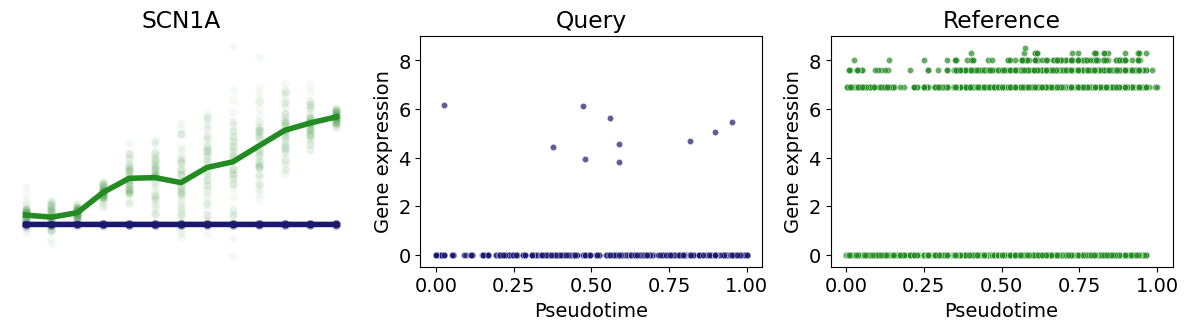

<Figure size 300x800 with 0 Axes>

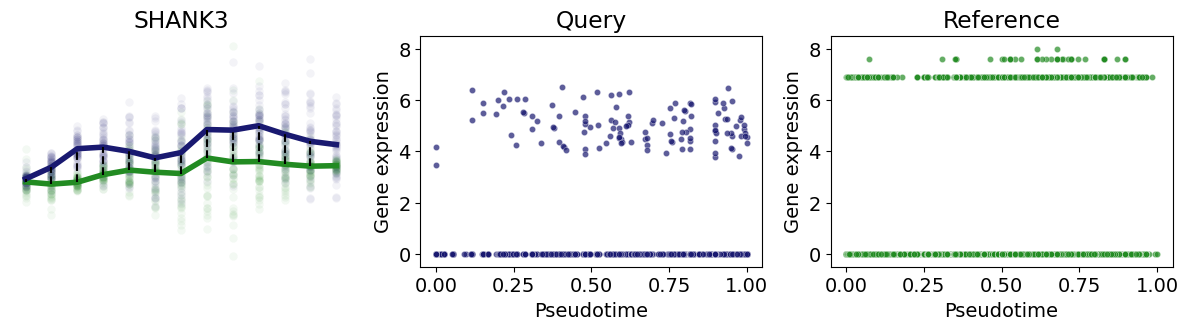

In [51]:
# # To access the genes in a particular cluster
cluster_id = 1
print(aligner.gene_clusters[cluster_id]) 
# VisualUtils.plotTimeSeries('TCF4', aligner, plot_cells=True)
# gene_obj = aligner.results_map['TCF4']
# alignment_str = gene_obj.alignment_str
#print(alignment_str)
#IL1RAPL1, NRXN3, PCDHB2, PCDHB3, PCDHB10, PCDHB16, WNT5A
plt.figure(figsize=(3, 8))  # 8 inches wide and 6 inches tall
VisualUtils.plotTimeSeries('SCN1A', aligner, plot_cells=True)
plt.savefig('./figures/SCN1A_exp.pdf', format='pdf', bbox_inches='tight')  # Save as PDF


plt.figure(figsize=(3, 8))  # 8 inches wide and 6 inches tall
VisualUtils.plotTimeSeries('SHANK3', aligner, plot_cells=True)
plt.savefig('./figures/SHANK3_exp.pdf', format='pdf', bbox_inches='tight')  # Save as PDF



gene_obj = aligner.results_map['SHANK3']
alignment_str = gene_obj.alignment_str
print(alignment_str)

#'ABLIM2', 'ACAT2', 'ACTN1', 'ADAM21'
# # To print all gene alignments in the cluster
# aligner.show_cluster_alignment_strings(cluster_id)

In [31]:
Synapse Assembly: IL1RAPL1, NRXN3, PCDHB2, PCDHB3, PCDHB10, PCDHB16, WNT5A
Positive Regulation of Endothelial Cell Proliferation:	 CCL11, HTR2B, PRKCA, VEGFD, WNT5A
Calcium-Dependent Cell-Cell Adhesion Via Plasma Membrane Cell Adhesion Molecules: PCDHB2, PCDHB3, PCDHB10, PCDHB16

SyntaxError: invalid syntax (1368133845.py, line 1)

## Analysing gene-level alignments

Mean alignment similarity percentage (matched %): 
44.7 %


,Gene,alignment_similarity_percentage,opt_alignment_cost,l2fc,color,abs_l2fc
104,EBF3,0.0,67.468115,-9.678964,red,9.678964
189,NAA10,0.0,67.468115,-8.752874,red,8.752874
19,ARF3,0.0,67.468115,-7.461913,red,7.461913
118,FRMPD4,0.0,67.468115,6.861519,red,6.861519
68,CNKSR2,0.0,67.468115,5.88583,red,5.88583
...,...,...,...,...,...,...
51,CDH2,1.0,21.742657,-0.280726,green,0.280726
348,UNC13A,1.0,11.083432,0.2473,green,0.2473
260,RFX3,1.0,9.479962,-0.102872,green,0.102872
316,TBCK,1.0,5.909275,-0.092021,green,0.092021


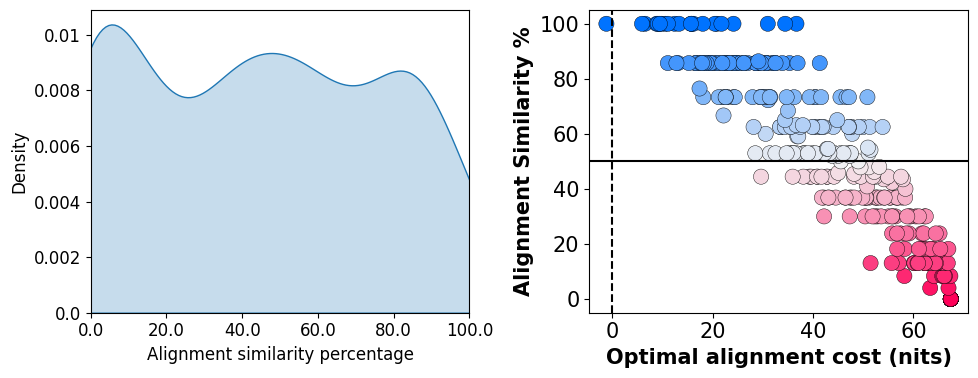

In [22]:
df_sim = aligner.get_stat_df() # ordered genes according to alignment similarity statistics 
df_sim.to_csv('data/genes2genes_similarity_psyad_sfari.txt', sep='\t', index=False, header=True)
df_sim

In [186]:
#earliest_match_sorted_genes_list = aligner.show_ordered_alignments() 


## Gene-set overrepresentation analysis on the top dissimilar genes


In [41]:
threshold_similarity = 0.2
topDEgenes = df[list((df['alignment_similarity_percentage'] <=threshold_similarity) & (df['l2fc'] <=-1))  ]['Gene']
# Calling wrapper function for GSEAPy enrichr inferface
pathway_df = PathwayAnalyser.run_overrepresentation_analysis(topDEgenes) 
pathway_df.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,mTORC1 Signaling,37/200,1.714117e-10,8.570584e-09,0,0,3.858896,86.774806,PPP1R15A;IDI1;CDKN1A;BTG2;ARPC5L;CXCR4;PLOD2;T...,8.066990,8.066990
50,KEGG_2021_Human,Pathways in cancer,65/531,4.331072e-09,1.281997e-06,0,0,2.393755,46.097615,ITGB1;CDKN1A;HSP90AB1;EPO;FGF2;CCND3;RPS6KA5;C...,5.892113,5.892113
1,MSigDB_Hallmark_2020,p53 Pathway,32/200,1.062411e-07,2.656028e-06,0,0,3.222581,51.746776,PPP1R15A;CDKN1A;BTG2;BTG1;NOTCH1;CD81;AK1;SLC3...,5.575767,5.575767
2,MSigDB_Hallmark_2020,Pperoxisome,21/104,3.262248e-07,4.318300e-06,0,0,4.257676,63.591281,SLC35B2;IDI1;CADM1;ELOVL5;IDH1;ABCC5;IDH2;HSD1...,5.364687,5.364687
3,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,31/200,3.454640e-07,4.318300e-06,0,0,3.100431,46.129386,PPP1R15A;BTG2;CDKN1A;CEBPB;BTG1;TNC;SOCS3;HES1...,5.364687,5.364687
51,KEGG_2021_Human,PI3K-Akt signaling pathway,46/354,1.415984e-07,2.095656e-05,0,0,2.540056,40.057374,ITGB1;CDKN1A;HSP90AB1;EPO;YWHAB;LAMA3;TNC;THBS...,4.678680,4.678680
4,MSigDB_Hallmark_2020,UV Response Up,25/158,3.148931e-06,2.330427e-05,0,0,3.166076,40.109270,CDKN1C;BTG2;BTG1;AMD1;CEBPG;CLTB;HNRNPU;ARRB2;...,4.632565,4.632565
5,MSigDB_Hallmark_2020,Cholesterol Homeostasis,16/74,3.165895e-06,2.330427e-05,0,0,4.627642,58.600171,IDI1;JAG1;HMGCS1;ANXA5;TMEM97;ACTG1;FADS2;SQLE...,4.632565,4.632565
6,MSigDB_Hallmark_2020,Hypoxia,29/200,3.262597e-06,2.330427e-05,0,0,2.861000,36.142979,CDKN1C;PPP1R15A;CDKN1A;BTG1;HDLBP;CXCR4;ENO2;R...,4.632565,4.632565
52,KEGG_2021_Human,Human papillomavirus infection,43/331,3.623756e-07,3.575439e-05,0,0,2.535055,37.596355,ITGB1;CDKN1A;HDAC2;NOTCH1;MAML2;LAMA3;TNC;UBR4...,4.446671,4.446671


In [190]:
threshold_similarity = 0.2
topDEgenes = df_sim[list((df_sim['alignment_similarity_percentage'] <=threshold_similarity) & (df_sim['l2fc'] >= 1))  ]['Gene']
# Calling wrapper function for GSEAPy enrichr inferface

In [192]:
pathway_df = PathwayAnalyser.run_overrepresentation_analysis(topDEgenes) 
pathway_df.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
29,KEGG_2021_Human,Nicotine addiction,15/40,7.239109e-18,1.295801e-15,0,0,42.019217,1658.373850,GABRB3;GRIA1;GABRA2;GABRB2;GRIA2;GABRA1;CACNA1...,14.887462,14.887462
30,KEGG_2021_Human,Glutamatergic synapse,20/114,3.680303e-16,3.293871e-14,0,0,15.117175,537.239722,GRIA1;GRIA2;PRKCB;CACNA1A;GRIK2;ADCY1;ADCY8;GR...,13.482293,13.482293
31,KEGG_2021_Human,Morphine addiction,17/91,2.125848e-14,1.268422e-12,0,0,16.163421,508.857171,GABRB3;GABRA2;GABRB2;GABRA1;KCNJ6;PRKCB;PDE4D;...,11.896736,11.896736
32,KEGG_2021_Human,Retrograde endocannabinoid signaling,20/148,6.644480e-14,2.973405e-12,0,0,11.082428,336.267503,GRIA1;GABRB3;GABRA2;GRIA2;GABRB2;GABRA1;KCNJ6;...,11.526746,11.526746
33,KEGG_2021_Human,Neuroactive ligand-receptor interaction,27/341,1.481618e-12,5.304193e-11,0,0,6.198115,168.823557,GABRB3;GRIA1;GABRB2;GRIA2;THRB;GRIK2;HTR2A;HTR...,10.275381,10.275381
34,KEGG_2021_Human,Calcium signaling pathway,20/240,5.264896e-10,1.570694e-08,0,0,6.417655,137.111844,RYR2;NTRK2;PRKCB;NTRK3;CACNA1A;ADCY1;HTR2A;HTR...,7.803908,7.803908
35,KEGG_2021_Human,Circadian entrainment,13/97,1.927889e-09,4.929887e-08,0,0,10.729430,215.305750,GRIA1;GUCY1A2;GRIA2;RYR2;KCNJ6;PRKCB;ADCY1;ADC...,7.307163,7.307163
36,KEGG_2021_Human,GABAergic synapse,12/89,7.602310e-09,1.701017e-07,0,0,10.770258,201.347964,GABRB3;GABRA2;GABRB2;GABRA1;KCNJ6;PRKCB;CACNA1...,6.769291,6.769291
37,KEGG_2021_Human,Long-term potentiation,10/67,5.102371e-08,1.014805e-06,0,0,12.051895,202.363080,GRIA1;GRIA2;GRM5;PRKCB;ADCY1;PLCB1;ADCY8;GRIN2...,5.993617,5.993617
38,KEGG_2021_Human,Serotonergic synapse,12/113,1.154185e-07,2.065991e-06,0,0,8.200948,131.007698,GABRB3;GABRB2;KCNJ6;HTR7;MAOB;KCND2;PRKCB;CACN...,5.684872,5.684872


In [189]:
threshold_similarity = 0.7
topDEgenes = df_sim[list(df_sim['alignment_similarity_percentage'] >=threshold_similarity)]['Gene']
# Calling wrapper function for GSEAPy enrichr inferface
pathway_df = PathwayAnalyser.run_overrepresentation_analysis(topDEgenes) 
pathway_df.head(20)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
44,KEGG_2021_Human,Glutamatergic synapse,15/114,1.127773e-07,0.000014,0,0,6.245577,99.915808,GRIK5;PLA2G4C;ITPR2;CACNA1D;GRIK1;GNAI1;GLS;GN...,4.857873,4.857873
43,KEGG_2021_Human,Cholinergic synapse,15/113,1.001388e-07,0.000014,0,0,6.309632,101.690501,CACNA1B;ITPR2;CACNA1D;GNAI1;GNG13;ADCY9;GNG2;K...,4.857873,4.857873
45,KEGG_2021_Human,Phospholipase D signaling pathway,16/148,6.646277e-07,0.000054,0,0,4.998582,71.100018,DGKG;SPHK2;PLA2G4C;GAB1;LPAR2;DGKZ;DNM1;ADCY9;...,4.263608,4.263608
0,MSigDB_Hallmark_2020,Estrogen Response Early,18/200,2.023868e-06,0.000087,0,0,4.085376,53.561325,FARP1;SVIL;CISH;MAST4;TPBG;ITPK1;RASGRP1;IGF1R...,4.060349,4.060349
46,KEGG_2021_Human,Axon guidance,17/182,2.337604e-06,0.000144,0,0,4.250604,55.114966,SEMA5A;NRP1;ARHGEF12;SEMA4D;ROCK2;SEMA6D;L1CAM...,3.842354,3.842354
48,KEGG_2021_Human,Dopaminergic synapse,14/132,4.149586e-06,0.000170,0,0,4.875467,60.419233,CACNA1B;ITPR2;CACNA1D;GNAI1;GNG13;MAPK10;PPP3C...,3.769211,3.769211
47,KEGG_2021_Human,Serotonergic synapse,13/113,3.692789e-06,0.000170,0,0,5.335772,66.745854,HTR1F;PLA2G4C;CACNA1B;ITPR2;CACNA1D;HTR3A;GNAI...,3.769211,3.769211
49,KEGG_2021_Human,"Growth hormone synthesis, secretion and action",13/119,6.582163e-06,0.000231,0,0,5.032191,60.039813,ITPR2;CACNA1D;PTK2;GNAI1;MAPK10;ADCY9;SOCS1;GN...,3.635794,3.635794
50,KEGG_2021_Human,GABAergic synapse,11/89,1.031274e-05,0.000289,0,0,5.770472,66.257316,NSF;GABBR2;ADCY9;GNG2;GNG7;CACNA1B;CACNA1D;PRK...,3.539364,3.539364
51,KEGG_2021_Human,Human cytomegalovirus infection,18/225,1.056680e-05,0.000289,0,0,3.587328,41.102864,ARHGEF11;ARHGEF12;ROCK2;PTGER3;ITPR2;PTK2;GNAI...,3.539364,3.539364


In [189]:
(df['alignment_similarity_percentage'] >=0.6).value_counts()

alignment_similarity_percentage
False    3822
True      497
Name: count, dtype: int64

MIIDDMMMMMM
MIIDDMMMMMM

01234567890 Alignment index 
0  12345678 Reference index
*--********
***--******
012  345678 Query index
MIIDDMMMMMM 5-state string 


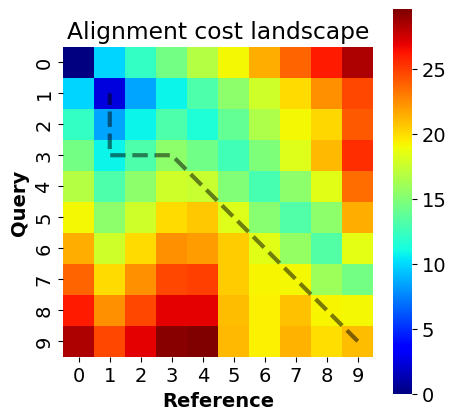

In [190]:
gene_obj = aligner.results_map['SEMA5A']
alignment_str = gene_obj.alignment_str
print(alignment_str)
print(VisualUtils.color_al_str(alignment_str)) 
print()
print(gene_obj.al_visual)
# Alignment landscape of costs (Note: dashed black path is the optimal alignment)
gene_obj.landscape_obj.plot_alignment_landscape()
# Note: optimal path diagonals represent matches; 
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

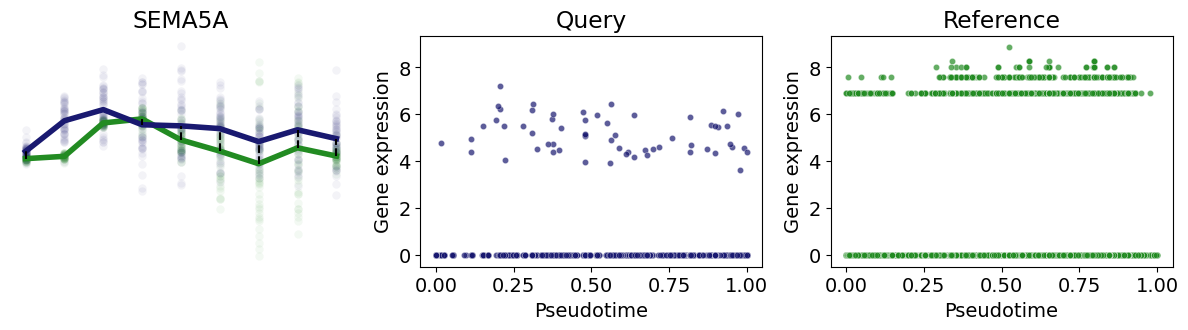

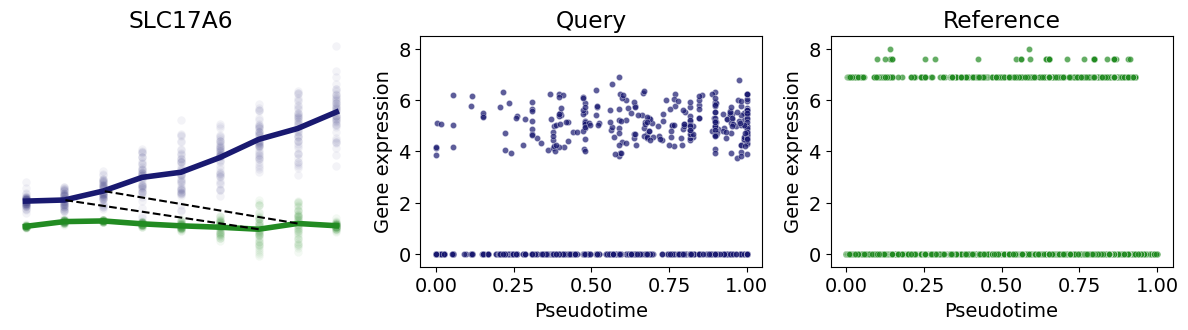

In [55]:
VisualUtils.plotTimeSeries('SEMA5A', aligner, plot_cells=True)
VisualUtils.plotTimeSeries('SLC17A6', aligner, plot_cells=True)



In [44]:
#(adata_ref.obs[["subtype_uni",'Batch']]).value_counts()
#(adata_ref.obs.cell_type_uni).value_counts()
#(adata_ref.obs.subtype_uni).value_counts()
#adata_ref.obs[["subclass",'Batch']].value_counts()

In [30]:
subtypes_to_keep <- c("PN_dev", "L2-3_CUX2_dev-fetal", "L2-3_CUX2_dev-4", "L2-3_CUX2_dev-6", "L2-3_CUX2_dev-2", "L2-3_CUX2_dev-3", "L2-3_CUX2_dev-5", "L2-3_CUX2_dev-1", "L2_CUX2_LAMP5_dev", "L2_CUX2_LAMP5", "L3_CUX2_PRSS12", "EN_L2_3_IT_NTNG1", "EN_L2_3_IT_PDGFD")
cells_to_keep <- which(colData(cds)$subtype_uni %in% subtypes_to_keep)
cds_subset <- cds[, cells_to_keep]
plot_cells(cds_subset, color_cells_by = "subtype_uni", label_leaves = F, label_branch_points = F, label_principal_points = F, label_groups_by_cluster = F, group_label_size = 3)


,X.orig.ident.,X.nCount_RNA.,X.nFeature_RNA.,X.nCount_originalexp.,X.nFeature_originalexp.,X.Batch.,X.SubID.,X.Age.,X.Sex.,X.PMI.,...,X.leiden.,X.mat.dev.,X.cell_type.,X.major_clust.,X.sub_clust.,X.combined.leiden.,X.cell_type_uni_leiden.,X.ident.,X.Size_Factor.,time
H1735-1-CTGCCATGTATCCCTC-0-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,10.321806
CTGAATGAGGAGAGTA-RL2105_627d_v3-Lister,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,9.164660
CGAGGCTTCAGTCATG-RL2107_ga24_v3-Lister,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,0.289334
AAATGGATCCATTTGT-RL2109_4yr_v3-Lister,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,8.285204
M55015-4-GTTGTAGTCACCTTGC-1-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,12.600623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1324-1-TTCTCTCTCCAACCAA-0-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,12.424001
M571120-2-TGAGGAGGTCTGCATA-1-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,8.671670
M16899-1-CATCGGGGTCCCTGTT-0-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,13.254703
H1735-2-GCTACAATCCTTATCA-1-Aging,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Batch,SubID,Age,Sex,PMI,...,leiden,mat.dev,cell_type,major_clust,sub_clust,combined.leiden,cell_type_uni_leiden,ident,Size_Factor,13.281554


In [ ]:
n_bins = 14

## G2G trajectory alignment

In [ ]:
# define the gene list to align
gene_list = adata_ref.var_names 
print(len(gene_list),'genes')

In [ ]:
# input_dir = '../notebooks/data/'
# adata_ref = anndata.read_h5ad(input_dir + 'adata_pam_local.h5ad') # Reference dataset
# adata_query = anndata.read_h5ad(input_dir +'adata_lps_local.h5ad') # Query dataset


#/sc/arion/projects/CommonMind/aging/hui/submission/files/integrated_EN_con_adata.h5ad

In [2]:
import genes2genes

/sc/arion/projects/CommonMind/aging/hui/submission/files/integrated_*_con_afterCombination_cds_compressed.RDS
Besides, you can check the example for extracting pseudotime and expression information from the jupyter notebook:
/sc/arion/projects/CommonMind/aging/hui/scripts/tests/pseudotime_aging_EN_example.ipynb
(***Note: Data in Jupiter notebook is just an example, NOT the latest file***).
 
You can also check figures from our submitted manuscript to clarify the detailed trajectories for different lineages (S3-4)


ModuleNotFoundError: No module named 'genes2genes'

In [ ]:

sce <- SingleCellExperiment(assays = list(counts = expr), 
                            colData = cell_meta, 
                            rowData = feature_data)
sce
writeH5AD(sce, "test2.h5ad")


In [ ]:
# adata_query = anndata.read_h5ad('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge_rawcount.h5ad')

# if isinstance(adata_query.X, np.ndarray):
#     counts = adata_query.X
# else:
#     counts = adata_query.X.A  # 将稀疏矩阵转换为稠密格式
    
# total_counts = counts.sum(axis=1)

# # 计算CPM
# cpm = (counts / total_counts[:, None]) * 1e6

# log_cpm = np.log1p(cpm)  # np.log1p 计算 log(x + 1)

# from scipy.sparse import csr_matrix
# cpm_sparse = csr_matrix(log_cpm)

# # 将CPM结果存入 AnnData 对象
# adata_query.layers['cpm'] = cpm_sparse
